# Admissions markets with a single score and MNL choice

Max Kapur | maxkapur.com

*N.B.* This is a working document, more of a set of personal notes than a finished product. Please see my other Github repositories for somewhat more polished discussions of admissions markets.

------

(I have moved most of the text to the LaTeX file now. Just archiving a few bits I want to have in Markdown format here.)

## Demand function
The first quantity we need to define is the *demand function,* which indicates how many students will attend each school given the school's quality $\gamma$ and some information about the school's selectivity. Specifically, each school sets a *cutoff* $p_c$ and admits all students whose score exceeds the cutoff. The demand function $D_c(\gamma, p)$ indicates how many students come to school $c$, representated as a fraction of the total number of students in the market. Observe that $D_c$ is a function not just of $p_c$ but also of the cutoffs at all the other schools, since if another school becomes more selective, the demand at $c$ may increase.

Let's figure out this function. First, sort the schools by cutoff, i.e. so that

$$p_1 \leq p_2 \leq \dots \leq p_{|C|}$$

Ties may be broken arbitrarily.

Then there are only $|C| + 1$ possible consideration sets for each student: 

| Symbol          | Consideration&nbsp;set                          | Probability           |
|-----------------|--------------------------------------------|-----------------------|
| $C_{[0]}$       | $\varnothing$                              | $p_1$                 |
| $C_{[1]}$       | $\left\{ c_1 \right\}$                     | $p_2 - p_1$           |
| $C_{[2]}$       | $\left\{ c_1, c_2 \right\}$                | $p_3 - p_2$           |
| $\vdots$        | $\vdots$                                   | $\vdots$              |
| $C_{[|C| - 1]}$ | $\left\{ c_1, \dots, c_{|C| - 1} \right\}$ | $p_{|C|} - p_{|C|-1}$ |
| $C_{[|C|]}$     | $\left\{ c_1, \dots, c_{|C|} \right\}$     | $1 - p_{|C|}$         |

This greatly simplifies the demand function. Letting $p_{|C|+1} \equiv 1$,

$$\begin{equation}D_c = \sum_{d=c}^{|C|} 
\underbrace{\frac{{\gamma_c}}{ \sum_{i=1}^d {\gamma_i}}}_{\substack{\text{prob. of choosing  }\\ c\text{ from assortment}}} 
\overbrace{\left(p_{d+1} - p_{d}\right)}^{\substack{\text{prob. of having}\\ \text{assortment }C_{[d]}}} \end{equation}$$

If at least one school has $p_c = 0$, then every student can get in somewhere, and $\sum_c D_c = 1$. Generally, there are $p_1$ students who get in nowhere, and $\sum_c D_c = 1 - p_1$.

## Computation

Let's get a computational environment going. First I define a container for the market information (capacity is discussed later), then the demand and appeal functions. I also define a function that returns the matrix $A$ discussed above; note that $A$ depends on $p$ via permutation. Finally, I define a market that computes the equilibrium for a given market using a generic t&acirc;tonnement procedure.

(Shifted all this to `OneTest.jl`.)

In [1]:
include("OneTest.jl")

using Plots, Plots.PlotMeasures
using LaTeXStrings
using Random, Distributions

### Quick usage example
Create a market and compute the equilibrium.

In [2]:
taipei = Market(log.([2., 1., 2.]), [0.2, 0.3, 0.1])
p_star = equilibrium(taipei)

3-element Vector{Float64}:
 0.6000000000000001
 0.4000000000000001
 0.7500000000000001

In [3]:
A, sort_order = demandmatrix(taipei, p_star)
inv_sort_order = invperm(sort_order)
B = A[inv_sort_order, inv_sort_order]

3×3 Matrix{Float64}:
 -0.666667   0.0   0.266667
  0.666667  -1.0   0.133333
  0.0        0.0  -0.4

In [4]:
B * diagm(p_star)

3×3 Matrix{Float64}:
 -0.4   0.0   0.2
  0.4  -0.4   0.1
  0.0   0.0  -0.3

In [5]:
15 * B

3×3 Matrix{Float64}:
 -10.0    0.0   4.0
  10.0  -15.0   2.0
   0.0    0.0  -6.0

In [6]:
demand(taipei, p_star)

3-element Vector{Float64}:
 0.19999999999999996
 0.3
 0.09999999999999995

For convenience, sort `taipei`.

In [7]:
taipei = sort(taipei)

Market{Float64}([0.0, 0.6931471805599453, 0.6931471805599453], [0.3, 0.2, 0.1], [1.0, 2.0, 2.0])

In [8]:
equilibrium(taipei)

3-element Vector{Float64}:
 0.4000000000000001
 0.6000000000000001
 0.7500000000000001

In [9]:
function plot_stable_match_cutoffs(market::Market; n_students_l::Vector{Int}=[10, 100, 1000])
    pl = plot(layout=(length(n_students_l), 1),
              topmargin=25px,
              leftmargin=90px,
              rightmargin=90px,
              xticks=0:0.2:1,
              size=(700, 150*length(n_students_l)),
              legend=nothing,
              xlim=(-0.025,1.025), xaxis=false,
              xtickwidth=0,
              yaxis=false, ylim=(-length(market)-0.4, 0.4),
              yticks=nothing)
    
    pm = deepcopy(pl)
    
    p_star = equilibrium(market)
    
    for (j, n_students) in enumerate(n_students_l)
        jitter = (.5 * rand(n_students) .- .25)
        
        # Compute a match using DA
        studentprefs, schoolprefs, caps, scores = makepreflists(market, n_students=n_students)

        match = DA(studentprefs, schoolprefs, caps)[1]

        match_y = match .% (length(market) + 1)

        cutoffs = zeros(length(market))

        for i in 1:length(market)
            cutoffs[i] = minimum(scores[match.==i])
        end

        colors=[:olivedrab, :dodgerblue, :crimson, :rebeccapurple, :goldenrod]

        # Plot
        hline!(pl[j], -length(market):0, c=:black, lw=0.4)
        
        for i in 1:length(market)
            vline!(pl[j], [cutoffs[i]], c=colors[i])
        end
        
        scatter!(pl[j], scores, -match_y + jitter, group=match, c=colors[match],
                 msw=0, m=:circle, ms=3, alpha=0.4)
        
        demands = [sum(match_y.==i) for i in 0:length(market)]
        capacity_labels = vcat("∞", caps)
        texteroo = ["$d/$c" for (d, c) in zip(demands, capacity_labels)]
     
        annotate!(pl[j], [(1.04, -i, text(texteroo[i+1], :left, :vcenter, 8))
                          for i in 0:length(market)])
        annotate!(pl[j], [(-0.04, -i, text(i==0 ? "None" : "School $i", :right, :vcenter, 8))
                          for i in 0:length(market)])

        annotate!(pl[j], [(cutoffs[i], .3, text(round(cutoffs[i], digits=4), 7, :bottom))
                 for i in 1:length(market)])
        
        annotate!(pl[j], [(0.1, -length(market)+.5, text("($n_students students)", 9, :hcenter, :vcenter))])
        
        if j == length(n_students_l)
            plot!(pl[j], xlabel="Score", xlabelfontsize=10)

        end
        
        
        
        
        # Exact cutoffs and free choice
        assn = zeros(Int, n_students)
        
        lowest_cutoff = minimum(p_star)
        
        for s in 1:n_students
            gotin_idx = (1:length(market))[scores[s].>=p_star]
            assn[s] = scores[s] < lowest_cutoff ? length(market) + 1 : gotin_idx[argmin(studentprefs[gotin_idx, s])]
        end
        
        assn_y = assn .% (length(market) + 1)
        
        hline!(pm[j], -length(market):0, c=:black, lw=0.4)
        
        for i in 1:length(market)
            vline!(pm[j], [p_star[i]], c=colors[i])
        end
        
        scatter!(pm[j], scores, -assn_y + jitter, group=assn, c=colors[assn],
                 msw=0, m=:circle, ms=3, alpha=0.4)
        
        demands = [sum(assn_y.==i) for i in 0:length(market)]
        capacity_labels = vcat("∞", caps)
        texteroo = ["$d/$c" for (d, c) in zip(demands, capacity_labels)]
     
        annotate!(pm[j], [(1.04, -i, text(texteroo[i+1], :left, :vcenter, 8))
                          for i in 0:length(market)])
        annotate!(pm[j], [(-0.04, -i, text(i==0 ? "None" : "School $i", :right, :vcenter, 8))
                          for i in 0:length(market)])
        
        annotate!(pm[j], [(p_star[i], .3, text(round(p_star[i], digits=4), 7, :bottom))
                 for i in 1:length(market)])
        
        annotate!(pm[j], [(0.1, -length(market)+.5, text("($n_students students)", 9, :hcenter, :vcenter))])
        
        if j == length(n_students_l)
            plot!(pm[j], xlabel="Score", xlabelfontsize=10)
        end
    end
    
    annotate!(pl[1], [(1.04, 1, text("Capacity", :left, :vcenter, 10, )),
                      (-0.04, 1, text("Placement", :right, :vcenter, 10))])
    annotate!(pm[1], [(1.04, 1, text("Capacity", :left, :vcenter, 10, )),
                      (-0.04, 1, text("Choice", :right, :vcenter, 10))])
    
    return pl, pm
end

plot_stable_match_cutoffs (generic function with 1 method)

In [10]:
mkt = Market(log.([1, 3, 2, 6]), [0.1, 0.2, 0.3, 0.2]) |> sort
p_star = equilibrium(mkt)

4-element Vector{Float64}:
 0.19999999999999996
 0.29999999999999993
 0.39999999999999997
 0.6

In [11]:
mkt.gamma

4-element Vector{Float64}:
 2.0
 1.0
 3.0000000000000004
 6.0

In [12]:
mkt.capacities

4-element Vector{Float64}:
 0.3
 0.1
 0.2
 0.2

In [13]:
demand(mkt, p_star)

4-element Vector{Float64}:
 0.3
 0.1
 0.20000000000000004
 0.20000000000000004

In [14]:
pl, pm = plot_stable_match_cutoffs(mkt; n_students_l=[20, 200, 2000])

# savefig(pl, "paper/plots/score-DA-placement.pdf")
# savefig(pl, "paper/plots/score-DA-placement.png")
# savefig(pm, "paper/plots/score-cutoff-choice.pdf")
# savefig(pm, "paper/plots/score-cutoff-choice.png")

(Plot{Plots.GRBackend() n=30}, Plot{Plots.GRBackend() n=30})

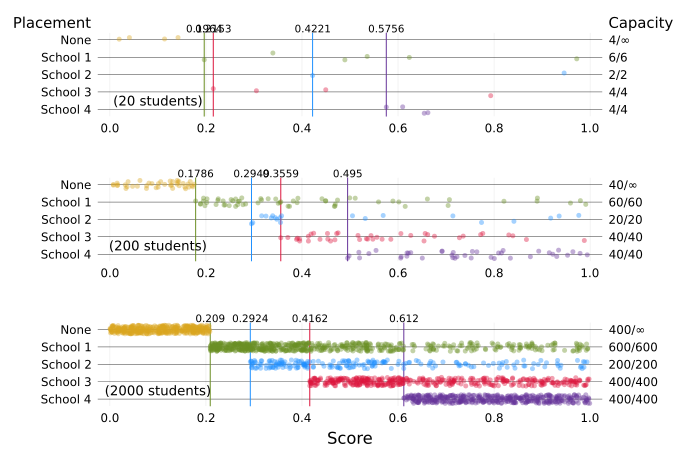

In [15]:
pl

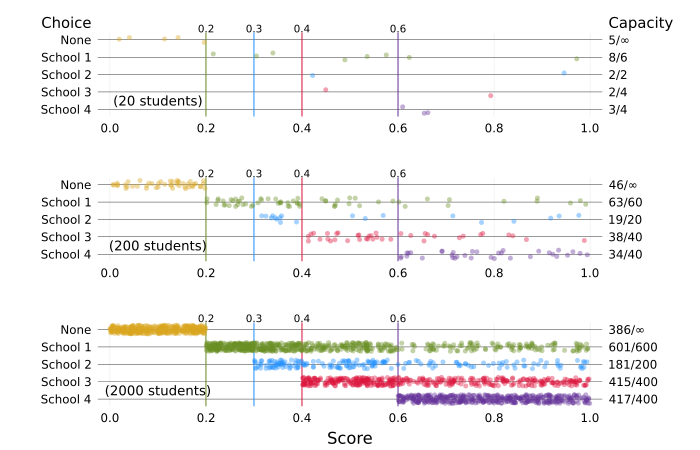

In [16]:
pm

In [17]:
function tatonnement_over_time(market)
    p_star = equilibrium(market)
    
    Ps = tatonnement(market, p0=repeat([0.15], length(market)), 
                     rate=0.2, damping=0.01)

    flip = hcat(Ps...)
    pl = plot(ylim=(0, 0.85), legend=:topleft, xlabel="iteration", ylabel="cutoff")
    
    colors=[:olivedrab, :dodgerblue, :crimson, :rebeccapurple, :goldenrod]
    
    for i in 1:length(market)
        hline!(pl, [p_star[i]], c=colors[i], label=nothing, ls=:dash, lw=0.75)
        plot!(pl, flip[i, :], c=colors[i], label="School $i", lw=1.5)
    end
    
    return pl
end

tatonnement_over_time (generic function with 1 method)

In [18]:
# pt = tatonnement_over_time(mkt)

# # savefig(pt, "paper/plots/tat-iter-cutoff.pdf")
# # savefig(pt, "paper/plots/tat-iter-cutoff.png")
# pt

## Checking the appeal and demand functions

Check that the matrices work as described:

In [19]:
mkt = Market(5)
p = rand(5)

A, sort_order = demandmatrix(mkt, p)

demand(mkt, p)[sort_order] ≈ A * p[sort_order] + mkt.gamma[sort_order]/sum(mkt.gamma)

true

Alternatively, 

In [20]:
inv_sort_order = invperm(sort_order)
B = A[inv_sort_order, inv_sort_order]

demand(mkt, p) ≈ B * p + mkt.gamma/sum(mkt.gamma)

true

The following fact is handy, because inverting a triangular matrix is easier than inverting a square matrix:

In [21]:
inv(A)[inv_sort_order, inv_sort_order] ≈ inv(B)

true

Same check for the appeal function:

In [22]:
appeal(mkt, p)[sort_order] ≈ (A * p[sort_order] .^2 + mkt.gamma[sort_order]/sum(mkt.gamma))/2 &&
appeal(mkt, p) ≈ (A[inv_sort_order, inv_sort_order] * p .^2 + mkt.gamma/sum(mkt.gamma))/2

true

In [23]:
mkt = Market(5)
p = rand(5)

A, sort_order = demandmatrix(mkt, p)
inv_sort_order = invperm(sort_order)
B = A[inv_sort_order, inv_sort_order]

5×5 Matrix{Float64}:
 -0.636482   0.194467   0.131015    0.0   0.0496927
  0.0       -0.305534   0.0905614   0.0   0.0343491
  0.0        0.0       -0.296403    0.0   0.0473604
  0.636482   0.111067   0.0748273  -1.0   0.0283813
  0.0        0.0        0.0         0.0  -0.159784

In [24]:
B\(mkt.capacities - mkt.gamma/sum(mkt.gamma))

5-element Vector{Float64}:
  0.1469433881770927
 -0.004604066836150429
 -0.178271056597941
  0.20959490391532926
  0.4717686011713477




- Stable matching. In 
- Market-clearing matching. A *semicentralized* admissions procedure like that used in Korea, in which the government determines a quota (i.e. capacity) of students who may be admitted to each school, and schools steadily admit students with lower and lower scores over the course of several admissions rounds until they fill their quota. The result is market-clearing cutoffs. (In the idealized case, this is actually a decentralized deferred acceptance algorithm; in practice, there is variation in scoring practices and limits on how many schools each student can apply to that prevent the equilibrium from being achieved exactly.)
- Competitive equilibrium. A *decentralized* admissions procedure like that used by private universities in the US. In this case, schools designate their own capacity, which is not necessarily a physical limitation on the number of students it can receive but rather a way of maintaining the school's selective reputation. In this case, schools must observe their demand from year over year and adjust their admissions cutoffs accordingly. If the adjustment process fits certain regularity conditions, then this process converges to the equilibrium defined above. The equilibrium is a fixed point of a tatonnement process. (In fact, a version of this process is how the function `quickeq()` computes equilibria.) (Show that this is a Nash EQ when schools use quality as their utility func.)

These observations are useful because if we can assume the market is at equilibrium, we can reduce the number of parameters:
- If $q$ and $\gamma$ are given, then there is only one equilibrium cutoff vector $p$, which we can find using `quickeq()`.
- If $\gamma$ and $p > 0$ are given, and we are told that the market is at equilibrium, then we can assume that $q = D(\gamma, p)$, which we can find using the `demand()` function.
- If $D$ and $p$ are given, and we are told that the market is at equilibrium, then we can solve for $\gamma$, as described [in a separate notebook](https://github.com/maxkapur/StudentPrefsRevOpt/blob/main/2_ReverseOptimization.ipynb). If $p>0$, we can additionally assume that $q = D$. 

In [25]:
function sort_demo(np=3)
    pl = plot(layout=(np, np), legend=nothing, ylim=(0,1), 
              yticks=0:0.25:1, size=(800, 700), xaxis=:log, share=:x)

    xlim = [1, 1.1]
    for j in 1:np^2
        mkt = Market(20)
        p_star = equilibrium(mkt)

        x = mkt.gamma ./ mkt.capacities
        scatter!(pl[j], x, p_star, ms=2, m=:x)
    end
    
    for i in (np^2-np+1):np^2
        annotate!(pl[i], [(10. ^2, -.35, text("γ / q", 9, :hcenter, :vcenter))])
        plot!(pl[i], bottommargin=50px)
    end
    
    for i in 1:np:np^2
        annotate!(pl[i], [(10. ^ -.5, 0.5, text("p*", 9, :right, :vcenter))])
        plot!(pl[i], leftmargin=50px)
    end
    
    plot!(pl, xlim=[10. ^.75, 10. ^3.25], xticks=10. .^(1:3))
    
    return pl
end
    
# ps = sort_demo(4)

# savefig(ps, "paper/plots/gammaq-pstar.pdf")
# savefig(ps, "paper/plots/gammaq-pstar.png")

# ps

sort_demo (generic function with 2 methods)

In [26]:
mkt = Market(6)
p_star = equilibrium(mkt)

A, sort_order = demandmatrix(mkt, p_star)
demand(mkt, p_star)[sort_order] ≈ A * p_star[sort_order] + mkt.gamma[sort_order]/sum(mkt.gamma)

true

In [27]:
inv_sort_order = invperm(sort_order)
B = A[inv_sort_order, inv_sort_order]

6×6 Matrix{Float64}:
 -0.164387    0.0   0.0        0.0362255   0.0         0.0
  0.0460576  -1.0   0.519409   0.0515922   0.105519    0.0948945
  0.0497778   0.0  -0.519409   0.0557595   0.114042    0.102559
  0.0         0.0   0.0       -0.220367    0.0         0.0
  0.0449731   0.0   0.0        0.0503774  -0.27358     0.0
  0.0235788   0.0   0.0        0.0264122   0.0540195  -0.197454

In [28]:
idx = p_star .> 0

6-element BitVector:
 1
 1
 1
 1
 1
 1

In [29]:
demand(mkt, p_star)

6-element Vector{Float64}:
 0.06481701216040035
 0.30492070306760916
 0.1554247215008048
 0.006370237535048005
 0.09436383527056057
 0.06547492802038136

In [30]:
B[:, idx] * inv(B)[idx, :] * (mkt.capacities - mkt.gamma) + mkt.gamma

6-element Vector{Float64}:
 0.06481701216040037
 0.3049207030676089
 0.15542472150080489
 0.006370237535048062
 0.09436383527056069
 0.06547492802038146

In [31]:
# Block matrix described below
# [ 0 T ;
#   0 I ] =
round.((B[:, idx] * inv(B)[idx, :])[sort_order, sort_order], digits=4)

6×6 Matrix{Float64}:
 1.0  0.0   0.0   0.0   0.0   0.0
 0.0  1.0  -0.0  -0.0  -0.0  -0.0
 0.0  0.0   1.0   0.0  -0.0   0.0
 0.0  0.0   0.0   1.0   0.0  -0.0
 0.0  0.0   0.0   0.0   1.0   0.0
 0.0  0.0   0.0   0.0   0.0   1.0

In [32]:
ϵ = 2e-5
mkt = Market(log.([.1, .2, .3, .4]), [.1, .15, .2, .25]) |> sort
mkt2 = Market(log.([.1, .2 + ϵ, .3, .4]), [.1, .15, .2, .25]) |> sort
(equilibrium(mkt2) - equilibrium(mkt)) ./ ϵ

4-element Vector{Float64}:
 -2.775557561562891e-12
  0.37496250374913215
 -0.6666666666710341
 -0.6250000000068701

In [33]:
1 .+ mkt.capacities ./ mkt.gamma .^2

4-element Vector{Float64}:
 10.999999999999996
  4.749999999999999
  3.2222222222222223
  2.5625

In [34]:
A, sort_order = demandmatrix(mkt, equilibrium(mkt))

([-1.0 0.6666666666666666 0.16666666666666669 0.06666666666666667; 0.0 -0.6666666666666666 0.3333333333333333 0.1333333333333333; 0.0 0.0 -0.4999999999999999 0.19999999999999996; 0.0 0.0 0.0 -0.4], [1, 2, 3, 4])

In [35]:
mkt = Market(log.([.1, .20001, .3, .4]), [.1, .15, .2, .25]) |> sort
equilibrium(mkt)

4-element Vector{Float64}:
 0.3
 0.32500374981250935
 0.34999333333333327
 0.37499374999999996

In [36]:
mkt.gamma ./ mkt.capacities

4-element Vector{Float64}:
 1.0000000000000002
 1.3334
 1.4999999999999998
 1.6

## Quality effects at equilibrium

Yet another expression for the equilibrium

In [37]:
function yetanother(mkt::Market)
    @assert mkt.capacities == sort(mkt).capacities
    p_star = zeros(length(mkt))
    
    Γ = sum(mkt.gamma)
    
    for c in 1:length(mkt)
        if c == length(mkt)
            p_star[c] = (1/Γ - mkt.capacities[c]/mkt.gamma[c]) * sum(mkt.gamma[i] for i in 1:c)
        else
            p_star[c] = (1/Γ - mkt.capacities[c]/mkt.gamma[c]) * sum(mkt.gamma[i] for i in 1:c) +
                        sum(mkt.gamma[j]/Γ - mkt.capacities[j] for j in (c+1):length(mkt))
        end
    end
    
    return max.(0, p_star)
end

yetanother (generic function with 1 method)

In [38]:
mkt = Market(6) |> sort
isapprox(equilibrium(mkt), yetanother(mkt)) && equilibrium(mkt) - tatonnement(mkt)[end]

6-element Vector{Float64}:
  0.0
  0.0
  0.0
 -0.0064540322749541
 -0.005673139478820199
 -0.009585375867218082

### Change in equilibrium with respect to a change in quality

In [144]:
# Analytic soln
function jac_gamma_p(mkt::Market)
    @assert mkt.capacities == sort(mkt).capacities
    p_star = equilibrium(mkt)
    
    Γ = sum(mkt.gamma)
    
    J = LowerTriangular(zeros(length(mkt), length(mkt)))
    
    for c in 2:length(mkt)
        if p_star[c] > 0
            for g in 1:c-1
                J[c, g] = -mkt.capacities[c]/mkt.gamma[c] 
            end
            J[c, c] = (mkt.capacities[c]/mkt.gamma[c]^2)*sum(mkt.gamma[i] for i in 1:c-1)
        end
    end
    
    return J
end

jac_gamma_p (generic function with 1 method)

In [150]:
# Numerical solution
function numerical_jac_gamma_p(mkt::Market)
    @assert mkt.capacities == sort(mkt).capacities
    ϵ = 2e-10
    J = zeros(length(mkt), length(mkt))
    
    for i in 1:length(mkt)
        pert = zeros(length(mkt))
        pert[i] = ϵ
        mkt1 = Market(log.(mkt.gamma - pert), mkt.capacities) |> sort
        mkt2 = Market(log.(mkt.gamma + pert), mkt.capacities) |> sort
        J[:, i] = (equilibrium(mkt2) - equilibrium(mkt1)) ./ (2ϵ)
    end
    
    return J
end

numerical_jac (generic function with 1 method)

In [158]:
mkt = Market(6) |> sort

isapprox(numerical_jac_gamma_p(mkt), jac_gamma_p(mkt), atol=1e-6)

true

In [169]:
equilibrium(mkt)

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.3058053293545047
 0.6443883797760154

In [189]:
# Analytic solution
function jac_gamma_demand(mkt::Market)
    @assert mkt.capacities == sort(mkt).capacities
    
    p_star = equilibrium(mkt)
    b = findfirst(p_star .> 0)
    denom = sum(mkt.gamma[i] for i in 1:b-1)^2
    

    J = zeros(length(mkt), length(mkt))
    
    if b > 1
        for c in 1:(b-1), g in 1:(b-1)
            if g == c
                J[c, c] = (1-sum(mkt.capacities[j] for j in b:length(mkt)))*sum(mkt.gamma[i] for i in setdiff(1:b-1, c))/denom
            else
                J[c, g] = mkt.gamma[c]*(sum(mkt.capacities[j] for j in b:length(mkt))-1)/denom
            end
        end
    end
    
    return J
end

# Numerical solution
function numerical_jac_gamma_demand(mkt::Market)
    @assert mkt.capacities == sort(mkt).capacities
    ϵ = 2e-10
    J = zeros(length(mkt), length(mkt))
    
    for i in 1:length(mkt)
        pert = zeros(length(mkt))
        pert[i] = ϵ
        mkt1 = Market(log.(mkt.gamma - pert), mkt.capacities) |> sort
        mkt2 = Market(log.(mkt.gamma + pert), mkt.capacities) |> sort
        J[:, i] = (demand(mkt2, equilibrium(mkt2)) - demand(mkt1, equilibrium(mkt1))) ./ (2ϵ)
    end
    
    return J
end

numerical_jac_gamma_demand (generic function with 1 method)

In [192]:
isapprox(numerical_jac_gamma_demand(mkt), jac_gamma_demand(mkt), atol=1e-5)

true

In [172]:
equilibrium(mkt)

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.3058053293545047
 0.6443883797760154

## References

- Abdulkadiroğlu, Atila, Yeon-Koo Che, and Yosuke Yasuda. 2015. &ldquo;Expanding &lsquo;Choice&rsquo; in School Choice.&rdquo; *American Economic Journal: Microeconomics* 7, no. 1 (Feb.): 1&ndash;42.